In [1]:
import numpy as np
import tensorflow as tf
import re
import time
from keras.models import Sequential
from keras .layers import Dense , LSTM ,Conv2D, Flatten
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler

In [2]:
!pip install investpy 

In [3]:
import investpy
df = investpy.get_stock_historical_data(stock='PFE',
                                        country='United States',
                                        from_date='01/01/2005',
                                        to_date='01/12/2020')

In [4]:
df.drop('Currency',axis=1,inplace=True)

In [5]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2005-01-03,27.31,27.35,26.45,26.45,46085200
2005-01-04,26.41,26.60,26.03,26.45,38701800
2005-01-05,26.48,26.52,26.15,26.27,27448800
2005-01-06,26.40,26.52,26.28,26.29,20256000
2005-01-07,26.54,26.60,26.27,26.30,22322600


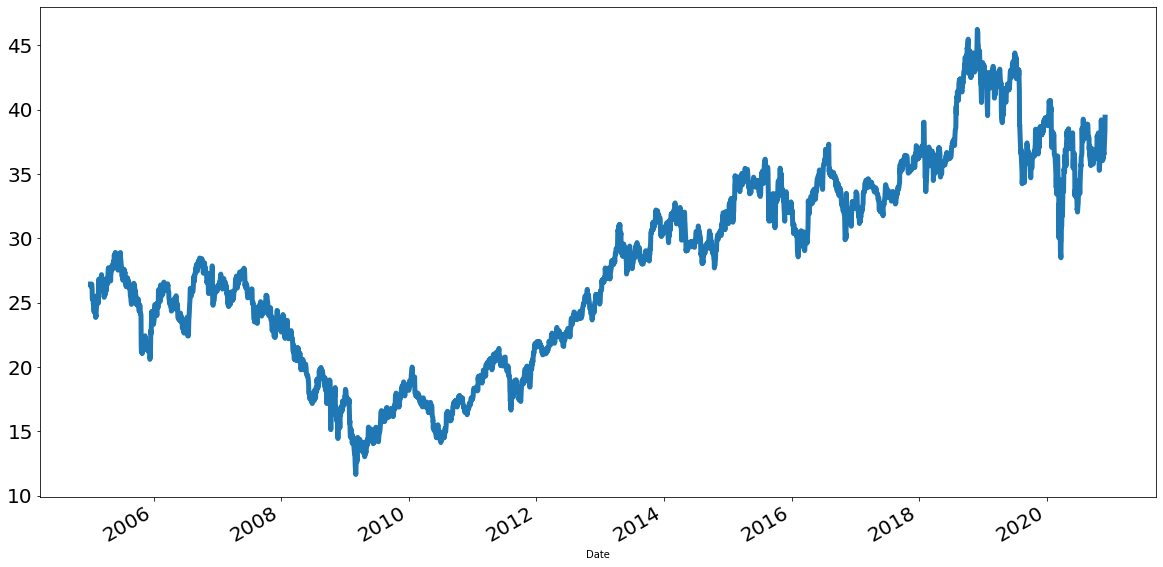

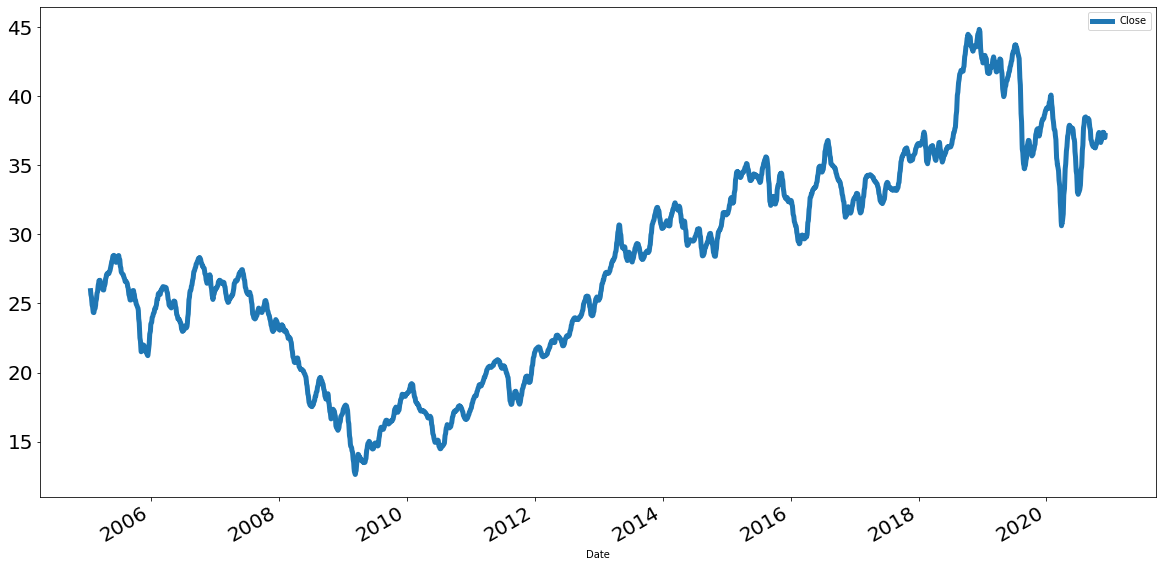

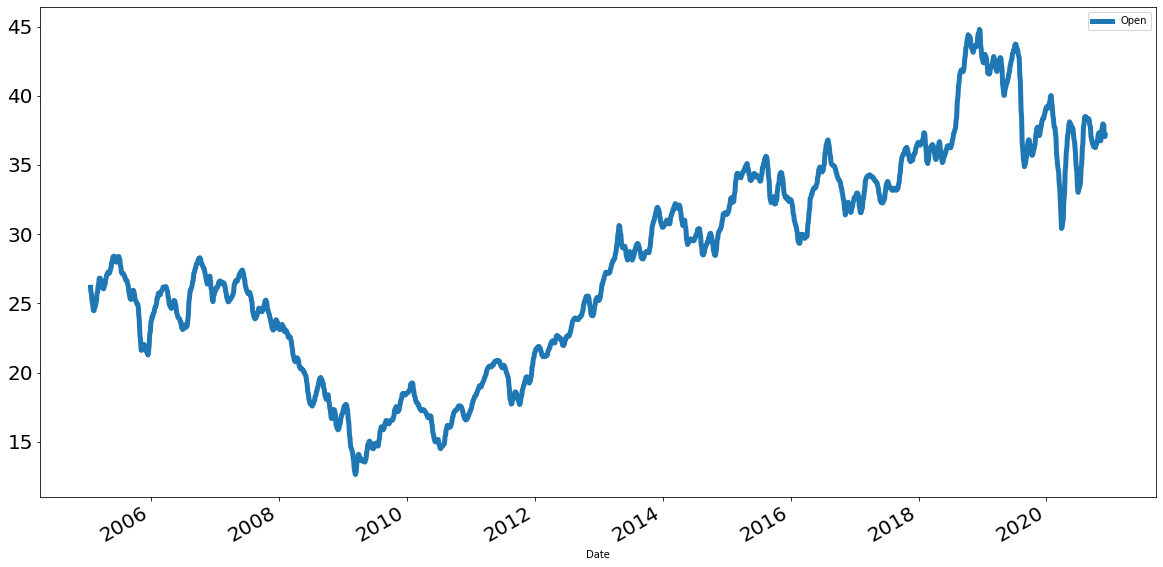

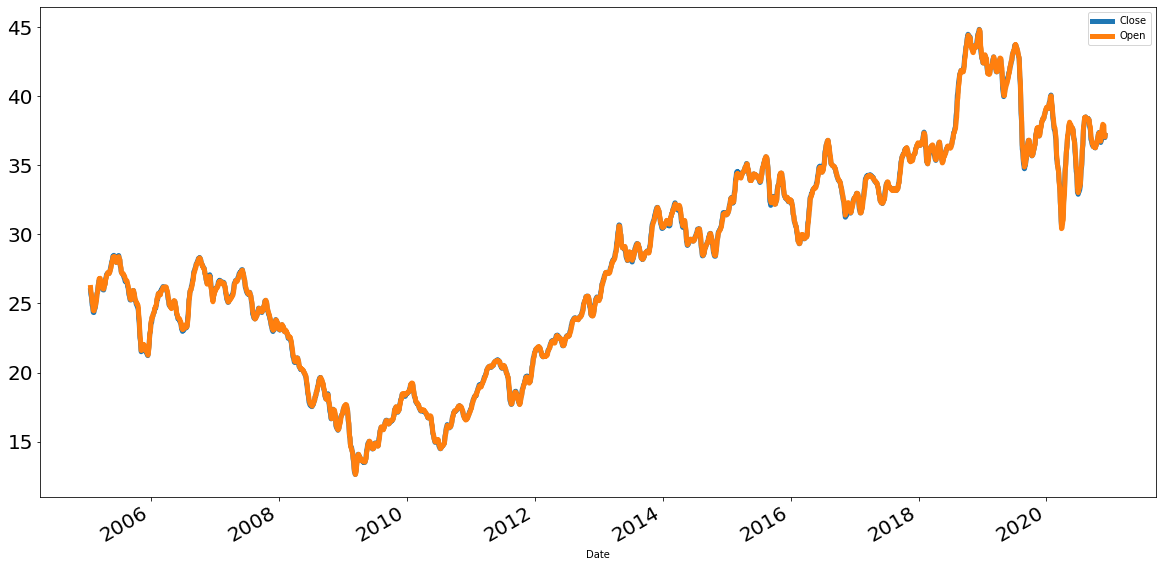

In [6]:
#Get The Profile 
fizer_profile = investpy.get_stock_company_profile(stock='PFE' , country='United States')

#Featch the trend
df['Close'].plot(figsize=(20,10), linewidth=5, fontsize=20)

close = df[['Close']]
close.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)


open_price = df[['Open']]
open_price.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)

df_rm = pd.concat([close.rolling(12).mean(), open_price.rolling(12).mean()], axis=1)
df_rm.plot(figsize=(20,10), linewidth=5, fontsize=20)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


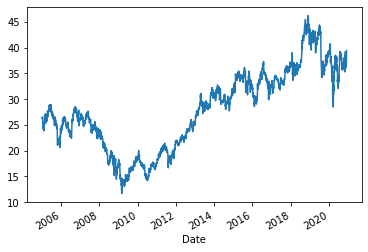

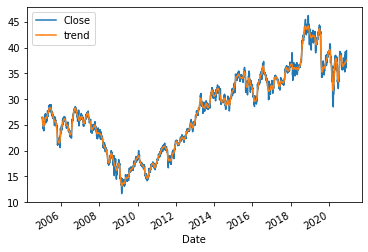

In [7]:

#Take The Trend from data
import statsmodels.api as sm
df['Close'].plot()
fizer_open , fizer_close  = sm.tsa.filters.hpfilter(df['Close'])

df['trend'] = fizer_close
df[['Close' , 'trend']].plot()

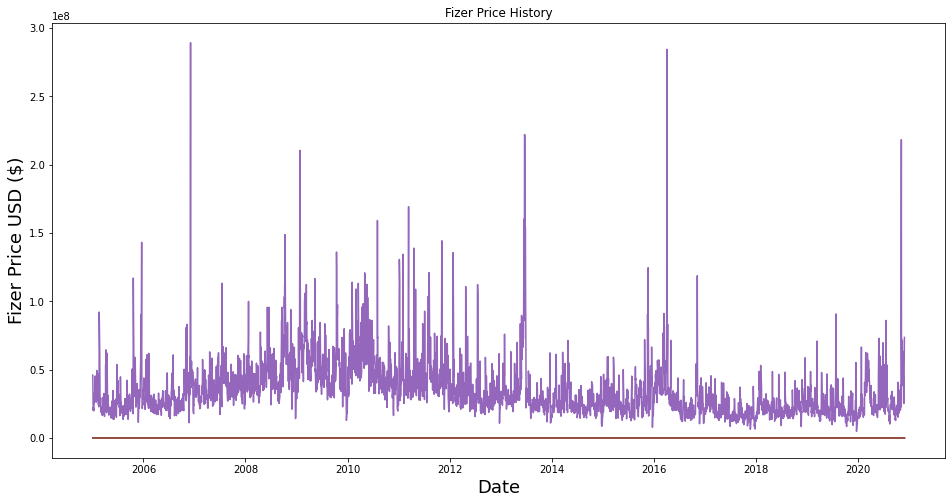

In [8]:
#Visulalize the closing and trend 
#Data
plt.figure(figsize=(16,8))
plt.title('Fizer Price History')
plt.plot(df)
plt.xlabel('Date' , fontsize=18)
plt.ylabel('Fizer Price USD ($)' ,fontsize=18)
plt.show()


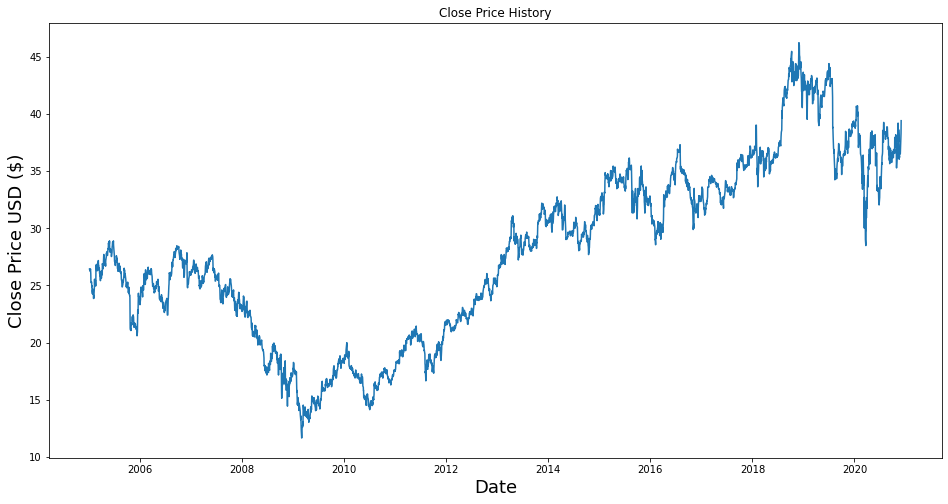

In [9]:

#Close
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date' , fontsize=18)
plt.ylabel('Close Price USD ($)' ,fontsize=18)
plt.show()

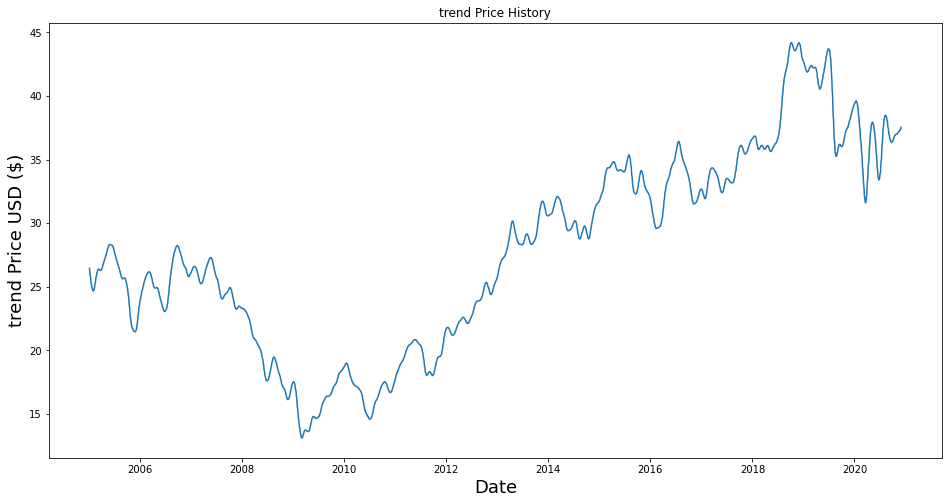

In [10]:
#Trend
plt.figure(figsize=(16,8))
plt.title('trend Price History')
plt.plot(df['trend'])
plt.xlabel('Date' , fontsize=18)
plt.ylabel('trend Price USD ($)' ,fontsize=18)
plt.show()

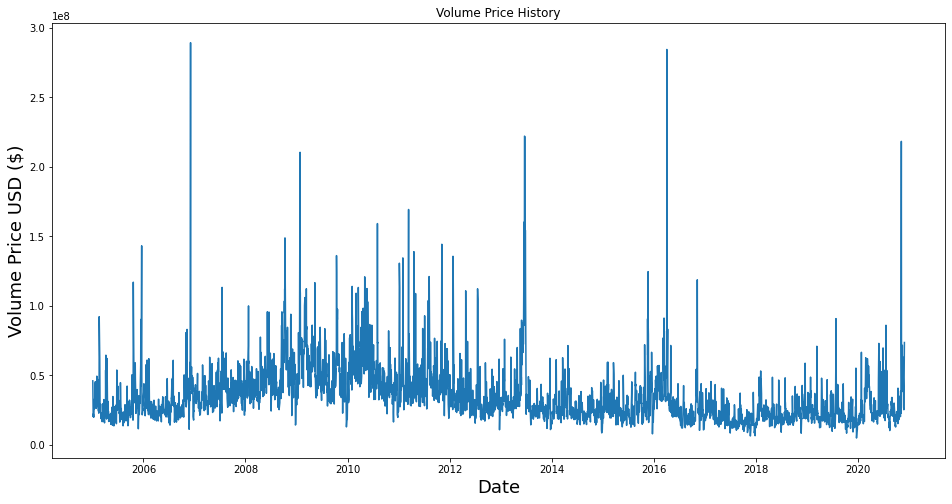

In [11]:
#Volume Price
plt.figure(figsize=(16,8))
plt.title('Volume Price History')
plt.plot(df['Volume'])
plt.xlabel('Date' , fontsize=18)
plt.ylabel('Volume Price USD ($)' ,fontsize=18)
plt.show()

In [12]:
data = df.filter(['Close'])

In [13]:
dataset = data.values

In [14]:
#Creat the traning data
#Get the number of row to train the data on
traning_data_len = math.ceil(len(dataset) * .8)

In [15]:
traning_data_len

3206

In [16]:
#Scale the data
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(dataset)

In [17]:
scaled_data

array([[0.4278276 ],
       [0.4278276 ],
       [0.42262077],
       ...,
       [0.73965866],
       [0.77089962],
       [0.80271912]])

In [18]:
#Create the Scaled training dataset

train_data = scaled_data[0:traning_data_len , :]

In [19]:
#Split the data to train and test
x_train = []
y_train = []

for i in range (60 ,len(train_data)):
    x_train.append(train_data[i-60:i ,0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print(len(x_train))
        print(len(y_train))

[array([0.4278276 , 0.4278276 , 0.42262077, 0.42319931, 0.42348857,
       0.42753833, 0.41914955, 0.41567833, 0.39542956, 0.39311542,
       0.39456176, 0.3824125 , 0.38530518, 0.37084177, 0.36447787,
       0.37402372, 0.37402372, 0.37662713, 0.36708128, 0.36158519,
       0.35290714, 0.35898178, 0.35435349, 0.36361007, 0.3832803 ,
       0.40179346, 0.38733005, 0.38733005, 0.39022274, 0.39976859,
       0.39224761, 0.38443737, 0.38761932, 0.43795198, 0.43187735,
       0.42377784, 0.42638126, 0.43968759, 0.42319931, 0.43245589,
       0.43245589, 0.43187735, 0.43939832, 0.44894417, 0.43679491,
       0.43621637, 0.43650564, 0.42522418, 0.43014174, 0.42319931,
       0.41625687, 0.4150998 , 0.40989297, 0.40642175, 0.39803298,
       0.4159676 , 0.41972809, 0.4214637 , 0.40439688, 0.42319931])]
[0.42262076945328325]
1
1
[array([0.4278276 , 0.4278276 , 0.42262077, 0.42319931, 0.42348857,
       0.42753833, 0.41914955, 0.41567833, 0.39542956, 0.39311542,
       0.39456176, 0.3824125 , 0

In [20]:
#Convert the x_train and y_train to numpy array
x_train , y_train =np.array(x_train) , np.array(y_train)

In [21]:
#Reshape the data
x_train = np.reshape(x_train ,(x_train.shape[0] , x_train.shape[1] , 1))
x_train.shape

(3146, 60, 1)

In [22]:
#Build the LSTM Model
model = Sequential()
model.add(LSTM(50 ,return_sequences=True , input_shape = (x_train.shape[1] , 1)))
model.add(LSTM(50 ,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam' ,loss='mean_squared_error')
model.fit(x_train ,y_train ,batch_size=1 ,epochs=7)

Epoch 1/7
3146/3146 [==============================] - 22s 6ms/step - loss: 0.0029
Epoch 2/7
3146/3146 [==============================] - 19s 6ms/step - loss: 3.2705e-04
Epoch 3/7
3146/3146 [==============================] - 19s 6ms/step - loss: 2.2990e-04
Epoch 4/7
3146/3146 [==============================] - 19s 6ms/step - loss: 2.5933e-04
Epoch 5/7
3146/3146 [==============================] - 19s 6ms/step - loss: 1.9605e-04
Epoch 6/7
3146/3146 [==============================] - 18s 6ms/step - loss: 1.8267e-04
Epoch 7/7
3146/3146 [==============================] - 18s 6ms/step - loss: 1.8548e-04


Create The Test Data Set

In [23]:
test_data = scaled_data[traning_data_len - 60 : , :]

In [24]:
x_test =[]
y_test = dataset[traning_data_len: , :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i ,0])

In [25]:
x_test =np.array(x_test)

In [26]:
x_test =np.reshape(x_test ,(x_test.shape[0] ,x_test.shape[1] ,1))

Get the model predection

In [27]:
pred = model.predict(x_test)

In [28]:
pred = scaler.inverse_transform(pred)

In [29]:
rmse = np.sqrt (np.mean (pred - y_test ) ** 2)
rmse

0.5706313143955188

In [30]:
train =data[:traning_data_len]
valid =data[traning_data_len:]
valid['Predections'] = pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


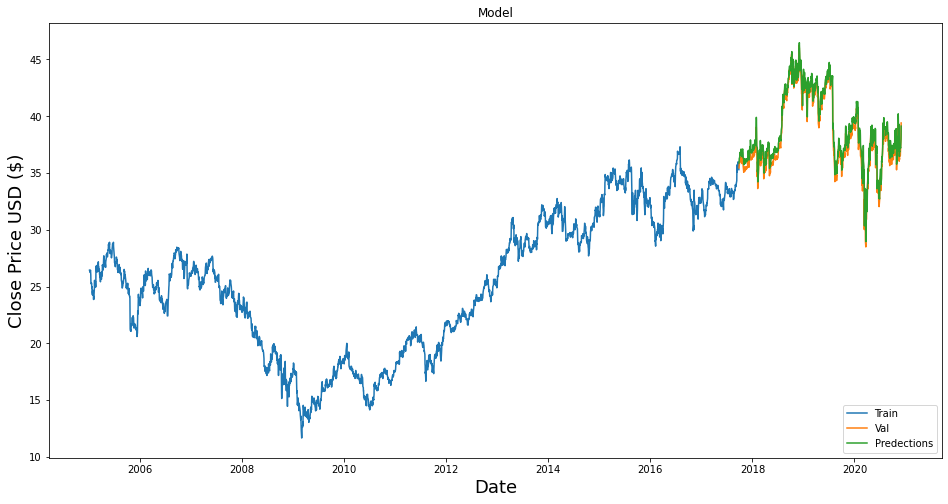

In [31]:
#Visulaize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date' , fontsize=18)
plt.ylabel('Close Price USD ($)' , fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close' , 'Predections']])
plt.legend(['Train' , 'Val' , 'Predections'] ,loc='lower right')
plt.show()

In [32]:
valid

,Close,Predections
Date,,
2017-09-27,35.45,35.882534
2017-09-28,35.60,36.101944
2017-09-29,35.70,36.287842
2017-10-02,36.07,36.391449
2017-10-03,36.14,36.789856
...,...,...
2020-11-24,36.60,37.223087
2020-11-25,36.53,37.305351
2020-11-27,37.23,37.192539
